## Imports



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_percentage_error

#Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import joblib

In [4]:
#!pip install tensorflow
name="A"
tariff='Std'

## Data-Split

In [5]:
def split_data(filename,tariff):
#     print('Input precise path for data including extension')
#     filename = input()
    fulldata = pd.read_csv(filename)
    fulldata['DateTime'] = pd.to_datetime(fulldata['DateTime'])
    
    if tariff=="ToU":
      start_date='2013-01-01'
    else: 
      start_date='2012-01-01'

    train_data = fulldata[(fulldata['DateTime'] >= start_date) & (fulldata['DateTime'] < '2014-01-01')].reset_index(drop = True)
    validation_data = fulldata[(fulldata['DateTime'] >= '2014-01-01') & (fulldata['DateTime'] < '2014-02-01')].reset_index(drop = True)
    test_data = fulldata[(fulldata['DateTime'] >= '2014-01-01') & (fulldata['DateTime'] < '2014-03-01')].reset_index(drop = True)
    return train_data, validation_data, test_data

In [74]:
def plot_predictions(df_plot):
    plt.figure(figsize=(18,6))
    sns.lineplot(x=df_plot['DateTime'],y=df_plot['Predicted'],label='Forecast')
    sns.lineplot(x=df_plot['DateTime'],y=df_plot['y'],label='Actual')
    plt.title('Electricity Consumption Prediction')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh/hh)')
    plt.legend()
    plt.show()

def return_mape(test,predicted):
    mape = mean_absolute_percentage_error(test, predicted)
    print("The  mean absolute percentage error is {}.".format(mape))

## Data-Processing 

In [11]:
def create_data(name,tariff):
    tdata, vdata, testd=split_data(f'https://storage.googleapis.com/energy_usage_prediction_903/df_{name}_avg_{tariff}_v1.csv',tariff)
    # add val and train for prophet
    combine_tr_vl=False
    
    if combine_tr_vl==True:
      pdata=pd.concat([tdata,vdata],axis=0).reset_index(drop=True)
    else:
      pdata=tdata

    global_average=False

    if global_average==False:
        # not for global average
        tdata.drop(columns='Unnamed: 0',inplace=True)
        testd.drop(columns='Unnamed: 0',inplace=True)
        vdata.drop(columns='Unnamed: 0',inplace=True)
        
    # group by
    df5=pdata.loc[:,['DateTime','KWH/hh']]
    df5.set_index('DateTime',inplace=True)

    train_df=df5.groupby(by=df5.index).mean()
    train_df=train_df.reset_index()

    test_df=testd.loc[:,['DateTime','KWH/hh']].groupby(by=testd['DateTime']).mean()
    test_df.reset_index(inplace=True)

    val_df=vdata.loc[:,['DateTime','KWH/hh']].groupby(by=vdata['DateTime']).mean()
    val_df.reset_index(inplace=True)
    
    return train_df,test_df,val_df


## Optional Parameters

### Holidays

In [12]:
holidays=pd.read_csv('https://storage.googleapis.com/energy_consumption_903/uk_bank_holidays.csv')
holidays.rename(columns={'Type':'holiday','Bank holidays':'ds'},inplace=True)
holidays.loc[:,'ds']=pd.to_datetime(holidays['ds'],format="%d/%m/%Y")
holidays.head()

,holiday,ds
0,Boxing Day,2012-12-26
1,Christmas Day,2012-12-25
2,Summer bank holiday,2012-08-27
3,Queen's Diamond Jubilee,2012-05-06
4,Spring bank holiday,2012-04-06


### Weather

In [13]:
## if using prophet
def get_weather(train_df, test_df,val_df,tariff):
    twd, vwd, testwd=split_data('https://storage.googleapis.com/weather-data-processed-for-le-wagon/cleaned_weather_hourly_darksky.csv',tariff)
  
    combine_tr_vl=False
    
    if combine_tr_vl==True:
      wd=pd.concat([twd,vwd],axis=0).reset_index(drop=True)
    else:
      wd=twd

    
    wd_filt=wd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
    wd_filt['DateTime']=pd.to_datetime(wd_filt['DateTime'])
    wd_filt[wd_filt.columns[1:].to_list()]=wd_filt[wd_filt.columns[1:].to_list()].interpolate(method='linear')
    
    test_wd=testwd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
    test_wd['DateTime']=pd.to_datetime(test_wd['DateTime'])
    
    val_wd=vwd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
    val_wd['DateTime']=pd.to_datetime(val_wd['DateTime'])
    # # wind = wd_filt['windSpeed'].interpolate(method='linear')
    # # rain = wd_filt['precipType_rain'].interpolate(method='linear')  
    train_wd=train_df[['DateTime']].merge(wd_filt,on='DateTime',how='inner')
    test_wd=test_df[['DateTime']].merge(test_wd,on='DateTime',how='inner')
    val_wd=val_df[['DateTime']].merge(val_wd,on='DateTime',how='inner')

    train_wd[train_wd.columns[1:].to_list()]=train_wd[train_wd.columns[1:].to_list()].interpolate(method='linear')
    test_wd[test_wd.columns[1:].to_list()]=test_wd[test_wd.columns[1:].to_list()].interpolate(method='linear')
    val_wd[val_wd.columns[1:].to_list()]=val_wd[test_wd.columns[1:].to_list()].interpolate(method='linear')

    return train_wd, test_wd,val_wd


In [26]:
#extra steps
train_df,test_df,val_df=create_data(name,tariff)
train_wd, test_wd,val_wd=get_weather(train_df,test_df,val_df,tariff)
regressors=train_wd.columns[1:].to_list()


## Train

In [33]:
def train_model(train_df,train_wd,holidays,regressors,add_weather=True): 
    train_df.rename(columns={"DateTime": "ds", "KWH/hh": "y"},inplace=True)
    m = Prophet(holidays=holidays,yearly_seasonality=20,changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.01)
    if add_weather==True: 
        for reg in regressors:
            train_df[reg]=train_wd[reg]
            m.add_regressor(reg, prior_scale=0.5, mode='multiplicative')
    m.fit(train_df)
    return m,train_df

In [35]:
m,train_df=train_model(train_df,train_wd,holidays,regressors,add_weather=True)

17:01:44 - cmdstanpy - INFO - Chain [1] start processing
17:01:57 - cmdstanpy - INFO - Chain [1] done processing


## Predict

In [46]:
def forecast_model(m,train_wd,test_wd,regressors,add_weather=True): 
    future = m.make_future_dataframe(periods=len(test_df), freq='30T')
    if add_weather==True:   
        future.loc[:,regressors]=pd.concat([train_wd[regressors],test_wd[regressors]],axis=0).reset_index(drop=True)
    fcst = m.predict(future)
    return fcst

In [53]:
f=forecast_model(m,train_wd,test_wd,regressors,add_weather=True)

## Plot

In [54]:
def plot_graphs(f):
    forecast=f.loc[f['ds']>='2014-02-01 00:00:00',['ds','yhat']]
    figure(figsize=(15,6))
    sns.lineplot(x=forecast['ds'],y=forecast['yhat'],label='Forecast');
    sns.lineplot(x=test_df['DateTime'],y=test_df['KWH/hh'],label='Actual');
    figure(figsize=(15,6))
    sns.lineplot(x=test_wd['DateTime'],y=test_wd['temperature'],label='Weather');
    return forecast

In [72]:
df_plot=test_df
df_plot=df_plot.merge(val_df,on='DateTime',how='outer').fillna('')
df_plot.drop(columns='KWH/hh_x',inplace=True)
df_plot.rename(columns={'key_0':'DateTime','KWH/hh_y':'y'},inplace=True)
df_plot['Predicted']=predicted_consumption['yhat']

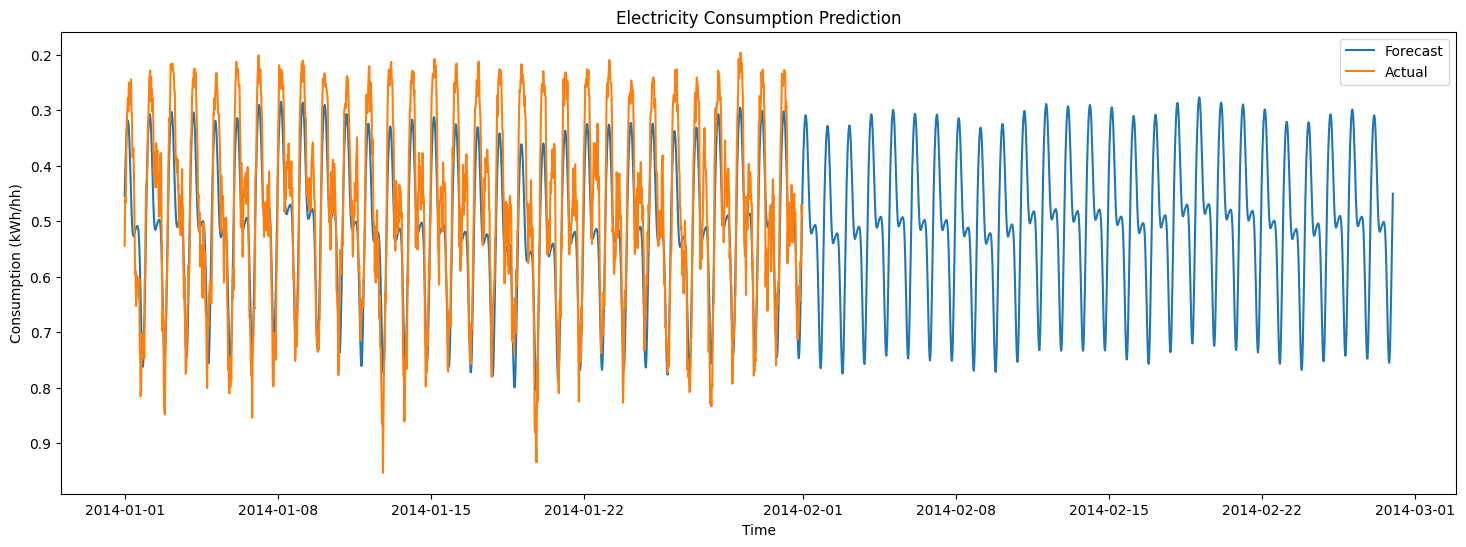

The  mean absolute percenatge error is 0.1904718636076784.


In [73]:
# Visualizing the results for LSTM
predicted_consumption=f.loc[f['ds']>='2014-01-01 00:00:00',['ds','yhat']].reset_index(drop=True)
df_plot=test_df
df_plot=df_plot.merge(val_df,on='DateTime',how='outer').fillna('')
df_plot.drop(columns='KWH/hh_x',inplace=True)
df_plot.rename(columns={'key_0':'DateTime','KWH/hh_y':'y'},inplace=True)
df_plot['Predicted']=predicted_consumption['yhat']
plot_predictions(df_plot)
# Evaluating our model
return_mape(test_df['KWH/hh'],predicted_consumption['yhat'])

In [ ]:
def evaluate(actual,forecasted):
    return np.round(mean_absolute_percentage_error(actual,forecasted),4)
#evaluate(test_df['KWH/hh'],forecast['yhat'])

## Metrics

In [77]:
def metric(predicted_consumption):
  #calculations
  #ofgem 2018 figures
  elecf=[1.196367,1.164487,1.052873,0.949678,0.910947,0.863625,0.846739,0.857709,0.877138,0.962776,1.095168,1.222492]
  #BEIS 2018 figures
  co2=0.309 # kg/kwh emission
  annual_consumption=round((predicted_consumption.sum()/(elecf[0]+elecf[1]))*np.sum(elecf),2)
  annual_co2=round(co2*annual_consumption,2)
  #if no renewable energy contribution either from supplier or from self generation
  return annual_consumption,annual_co2

annual_consumption,annual_co2=metric(predicted_consumption['yhat'])
print(f'You total predicted annual_consumption in {annual_consumption} kWh')
print(f'Your total predicted annual carbon footprint amounts to {annual_co2} kg')

You total predicted annual_consumption in 7200.34 kWh
Your total predicted annual carbon footprint amounts to 2224.91 kg


## Hyper-parameter Tuning

In [44]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, initial='366 days', period='180 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

best_params = all_params[np.argmin(mapes)]
print(best_params)

19:31:47 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:32:03 - cmdstanpy - INFO - Chain [1] done processing
19:32:05 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing
19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:37 - cmdstanpy - INFO - Chain [1] done processing
19:32:45 - cmdstanpy - INFO - Chain [1] done processing
19:33:00 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:22 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      mape
0                     0.001                     0.01  0.193470
1                     0.001                     0.10  0.195920
2                     0.001                     1.00  0.192501
3                     0.001                    10.00  0.188154
4                     0.010                     0.01  0.157806
5                     0.010                     0.10  0.158784
6                     0.010                     1.00  0.159328
7                     0.010                    10.00  0.158242
8                     0.100                     0.01  0.202028
9                     0.100                     0.10  0.264798
10                    0.100                     1.00  0.259754
11                    0.100                    10.00  0.260813
12                    0.500                     0.01  0.233849
13                    0.500                     0.10  0.529590
14                    0.500                     1.00  0